In [15]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt


In [16]:
class PCAAnalysis:
    def __init__(self, dataset_path):
        self.dataset_path = dataset_path

    def load_images(self):
        """Load and preprocess images."""
        images = []
        for file_name in sorted(os.listdir(self.dataset_path)):
            if file_name.endswith('.png'):  # Ensure only .png images are processed
                img = Image.open(os.path.join(self.dataset_path, file_name))
                img = img.resize((64, 64), Image.BILINEAR)  # Resize to uniform dimensions
                images.append(np.array(img))
        self.images = np.array(images, dtype=np.float32)
        self.images_flattened = self.images.reshape(self.images.shape[0], -1, 3)
        print(f"Loaded images with shape: {self.images.shape}")

    def perform_pca(self, X):
        """Perform PCA on the given data."""
        mean = np.mean(X, axis=0)
        X_centered = X - mean
        covariance_matrix = np.dot(X_centered.T, X_centered) / (X.shape[0] - 1)
        eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)
        sorted_indices = np.argsort(-eigenvalues)
        return eigenvalues[sorted_indices], eigenvectors[:, sorted_indices], mean

    def run(self):
        """Main method to execute PCA analysis."""
        self.load_images()
        channels = ["Red", "Green", "Blue"]
        pve_results = {}

        for i, color in enumerate(channels):
            X_channel = self.images_flattened[:, :, i]
            eigenvalues, eigenvectors, mean = self.perform_pca(X_channel)
            pve = eigenvalues / np.sum(eigenvalues)
            cumulative_pve = np.cumsum(pve)

            print(f"{color} Channel:")
            print(f"Proportion of Variance Explained (PVE): {pve[:10]}")
            print(f"Cumulative PVE: {cumulative_pve[:10]}")
            pve_results[color] = cumulative_pve

            # Reconstruct and visualize the first image
            k_values = [1, 10, 50, 100, X_channel.shape[1]]
            for k in k_values:
                top_k_eigenvectors = eigenvectors[:, :k]
                projection = np.dot((X_channel[0] - mean), top_k_eigenvectors)
                reconstruction = np.dot(projection, top_k_eigenvectors.T) + mean
                plt.imshow(reconstruction.reshape(64, 64), cmap="gray")
                plt.title(f"Reconstruction with k={k} components")
                plt.show()


Loaded images with shape: (10000, 64, 64, 3)
Red Channel:
Proportion of Variance Explained (PVE): [0.28929082 0.09373799 0.06788795 0.0585922  0.054195   0.04384447
 0.02887795 0.02049209 0.01681582 0.01630701]
Cumulative PVE: [0.28929082 0.3830288  0.45091677 0.50950897 0.56370395 0.6075484
 0.6364264  0.65691847 0.6737343  0.6900413 ]


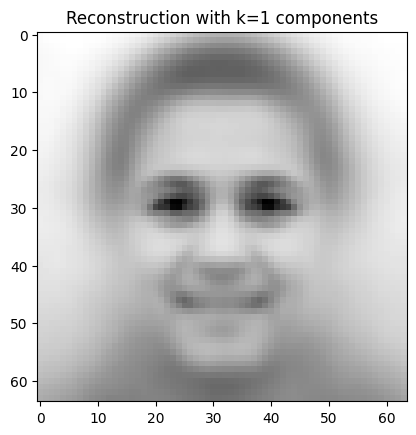

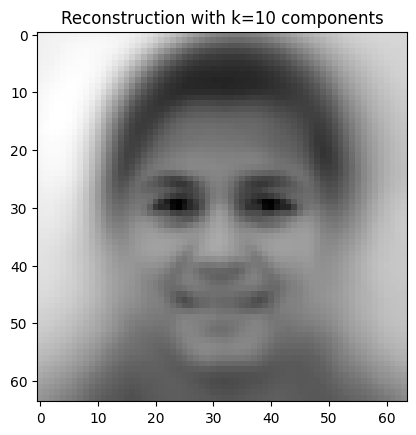

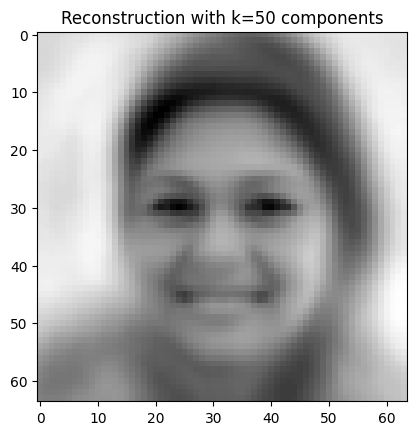

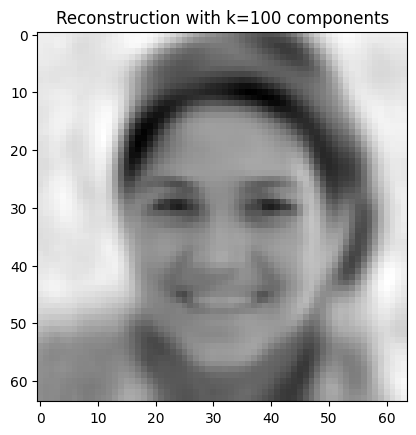

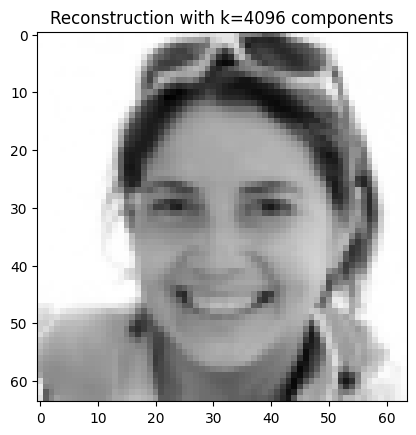

Green Channel:
Proportion of Variance Explained (PVE): [0.320411   0.08559318 0.08177432 0.05796602 0.04110711 0.03958216
 0.02568433 0.01855605 0.01663551 0.01604563]
Cumulative PVE: [0.320411   0.4060042  0.4877785  0.54574454 0.58685166 0.62643385
 0.65211815 0.6706742  0.68730974 0.7033554 ]


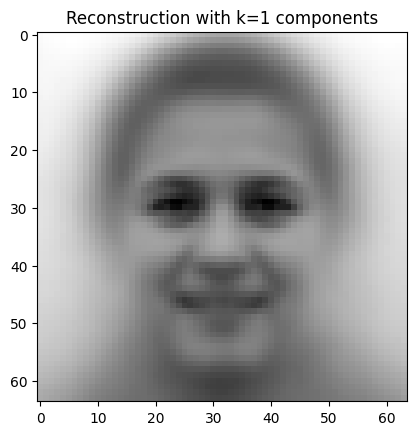

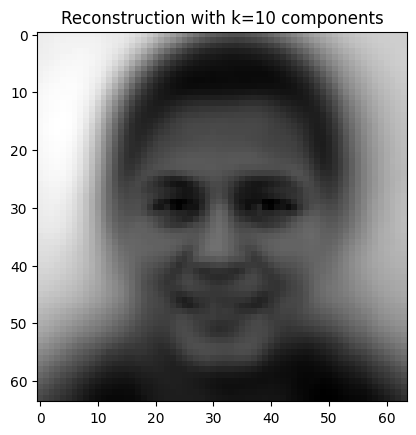

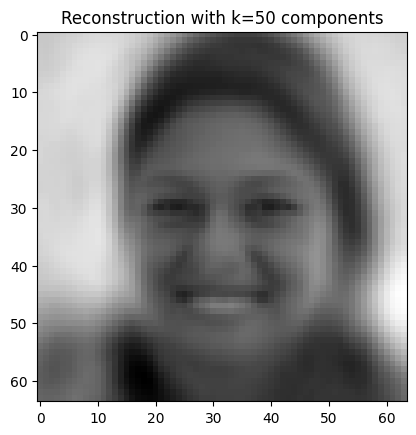

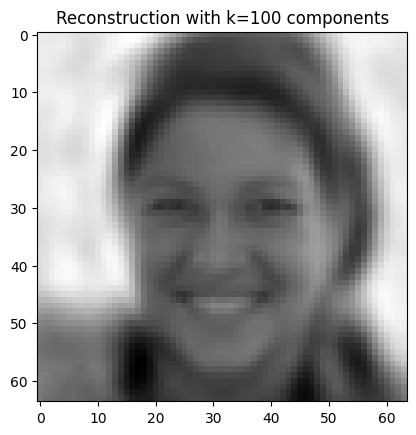

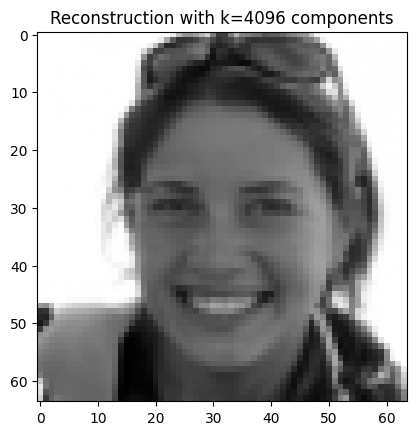

Blue Channel:
Proportion of Variance Explained (PVE): [0.3435794  0.08854059 0.08477065 0.05722818 0.03805416 0.03354398
 0.02486367 0.01717688 0.01624892 0.01553018]
Cumulative PVE: [0.3435794  0.43212    0.51689065 0.57411885 0.612173   0.645717
 0.6705807  0.68775755 0.7040065  0.71953666]


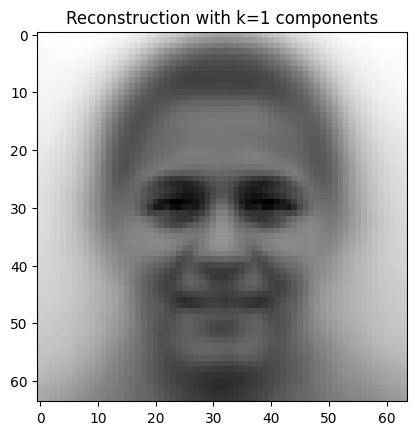

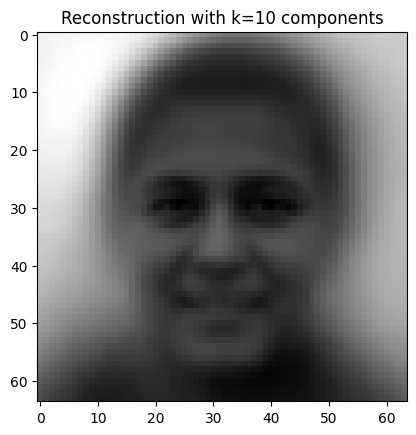

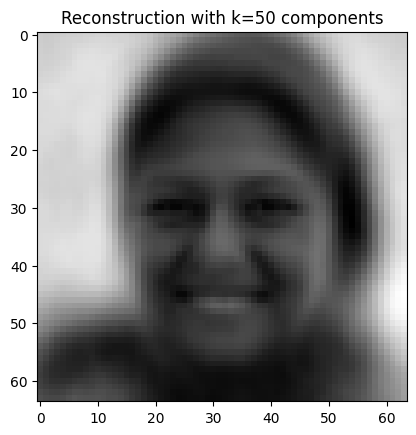

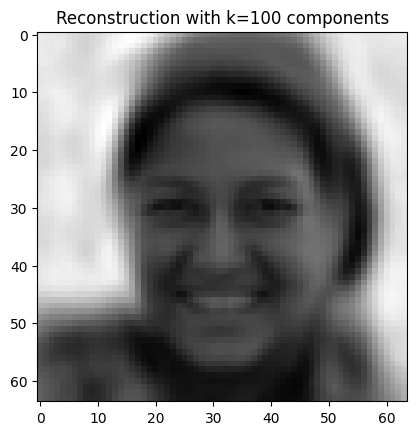

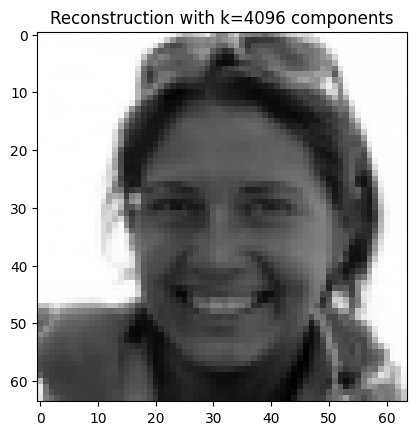

In [17]:
dataset_path = "/Users/elifsorguc/Desktop/Bilkent/ML/MachineLearning-PCA-LogReg/data/fake"

# Perform PCA Analysis
pca = PCAAnalysis(dataset_path)
pca.run()

In [18]:

class LogisticRegression:
    def __init__(self, learning_rate=5e-4, reg_lambda=1e-4, batch_size=200, epochs=100):
        self.learning_rate = learning_rate
        self.reg_lambda = reg_lambda
        self.batch_size = batch_size
        self.epochs = epochs

    def softmax(self, z):
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def cross_entropy_loss(self, y_true, y_pred):
        return -np.sum(y_true * np.log(y_pred)) / y_true.shape[0]

    def initialize_weights(self, input_size, num_classes):
        self.weights = np.random.normal(0, 1, (input_size, num_classes))
        self.bias = np.zeros((1, num_classes))

    def train(self, X_train, y_train):
        num_samples, num_features = X_train.shape
        num_classes = y_train.shape[1]
        self.initialize_weights(num_features, num_classes)

        for epoch in range(self.epochs):
            for i in range(0, num_samples, self.batch_size):
                X_batch = X_train[i:i + self.batch_size]
                y_batch = y_train[i:i + self.batch_size]

                logits = np.dot(X_batch, self.weights) + self.bias
                y_pred = self.softmax(logits)
                loss = self.cross_entropy_loss(y_batch, y_pred)

                grad_weights = np.dot(X_batch.T, (y_pred - y_batch)) / X_batch.shape[0]
                grad_bias = np.sum(y_pred - y_batch, axis=0, keepdims=True) / X_batch.shape[0]
                self.weights -= self.learning_rate * (grad_weights + self.reg_lambda * self.weights)
                self.bias -= self.learning_rate * grad_bias

            print(f"Epoch {epoch + 1}/{self.epochs}, Loss: {loss:.4f}")

    def predict(self, X):
        logits = np.dot(X, self.weights) + self.bias
        return np.argmax(self.softmax(logits), axis=1)

    def evaluate(self, X_test, y_test):
        predictions = self.predict(X_test)
        accuracy = np.mean(predictions == np.argmax(y_test, axis=1))
        print(f"Test Accuracy: {accuracy * 100:.2f}%")

In [19]:
# Example: Generating random data for demonstration
num_samples = 1000
num_features = 64 * 64 * 3
num_classes = 10


X_train = np.random.rand(num_samples, num_features).astype(np.float32)
y_train = np.eye(num_classes)[np.random.choice(num_classes, num_samples)]
X_test = np.random.rand(num_samples // 10, num_features).astype(np.float32)
y_test = np.eye(num_classes)[np.random.choice(num_classes, num_samples // 10)]

In [20]:

# Train and evaluate the logistic regression model
log_reg = LogisticRegression()
log_reg.train(X_train, y_train)
log_reg.evaluate(X_test, y_test)

Epoch 1/100, Loss: 77.9527
Epoch 2/100, Loss: 76.7534
Epoch 3/100, Loss: 75.6026
Epoch 4/100, Loss: 74.4955
Epoch 5/100, Loss: 73.4273
Epoch 6/100, Loss: 72.3966
Epoch 7/100, Loss: 71.4000
Epoch 8/100, Loss: 70.4405
Epoch 9/100, Loss: 69.5170
Epoch 10/100, Loss: 68.6239
Epoch 11/100, Loss: 67.7644
Epoch 12/100, Loss: 66.9365
Epoch 13/100, Loss: 66.1346
Epoch 14/100, Loss: 65.3576
Epoch 15/100, Loss: 64.6075
Epoch 16/100, Loss: 63.8878
Epoch 17/100, Loss: 63.2034
Epoch 18/100, Loss: 62.5583
Epoch 19/100, Loss: 61.9487
Epoch 20/100, Loss: 61.3656
Epoch 21/100, Loss: 60.8052
Epoch 22/100, Loss: 60.2665
Epoch 23/100, Loss: 59.7496
Epoch 24/100, Loss: 59.2548
Epoch 25/100, Loss: 58.7824
Epoch 26/100, Loss: 58.3323
Epoch 27/100, Loss: 57.9035
Epoch 28/100, Loss: 57.4958
Epoch 29/100, Loss: 57.1090
Epoch 30/100, Loss: 56.7402
Epoch 31/100, Loss: 56.3863
Epoch 32/100, Loss: 56.0465
Epoch 33/100, Loss: 55.7207
Epoch 34/100, Loss: 55.4090
Epoch 35/100, Loss: 55.1103
Epoch 36/100, Loss: 54.8232
E